In [45]:
from PIL import Image

import matplotlib.pyplot as plt

def draw_number(pixels):
    plt.figure()
    plt.imshow(pixels)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def load_emnist(key_path):
    import os
    if not os.path.isfile("~/.kaggle/kaggle.json"):
        !mkdir ~/.kaggle
        !mv {key_path} ~/.kaggle/kaggle.json
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install kaggle
        !kaggle datasets download -d crawford/emnist -p data

        import zipfile
        with zipfile.ZipFile("data/emnist.zip", 'r') as zip_ref:
            zip_ref.extractall("data/emnist")

def resize_images(images):
    res = []
    for img in images:
        r = img.reshape(28, 28).astype('uint8')
    
        b = Image.fromarray(r)
        f = b.resize((32, 32))

        res.append(np.array(f).astype('float32') / 255.0)
    return np.array(res)

In [46]:
load_emnist("kaggle.json")

mkdir: cannot create directory ‘/home/slinky/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
emnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
from tf_keras import models
from tf_keras import layers

from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
from tf_keras.utils import to_categorical


# Load the data
train = pd.read_csv("data/emnist/emnist-byclass-train.csv").to_numpy()
test = pd.read_csv("data/emnist/emnist-byclass-test.csv").to_numpy()

# Preprocess the data
train_labels = train[:, 0]
train_images = train[:, 1:]
test_labels = test[:, 0]
test_images = test[:, 1:]

train_images = resize_images(train_images)
test_images = resize_images(test_images)

print(train_images.shape)
print(train_images[0])

LB = LabelBinarizer()
train_labels = np.array(LB.fit_transform(train_labels))
test_labels = np.array(LB.fit_transform(test_labels))
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

print(train_labels.shape)
print(train_labels)

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
 
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(62, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels,
          epochs=50,  
          batch_size=32,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, checkpoint])

_, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

(697931, 32, 32)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(697931, 62)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Epoch 1/50
21799/21811 [============================>.] - ETA: 0s - loss: 0.5564 - accuracy: 0.8134
Epoch 1: val_loss improved from inf to 0.39742, saving model to model.h5
21811/21811 [==============================] - 69s 3ms/step - loss: 0.5563 - accuracy: 0.8134 - val_loss: 0.3974 - val_accuracy: 0.8553
Epoch 2/50
   55/21811 [..............................] - ETA: 1:02 - loss: 0.4285 - accuracy: 0.8551

/home/slinky/GatorNum/venv/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21811/21811 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.39742 to 0.38184, saving model to model.h5
21811/21811 [==============================] - 69s 3ms/step - loss: 0.4357 - accuracy: 0.8453 - val_loss: 0.3818 - val_accuracy: 0.8604
Epoch 3/50
21797/21811 [============================>.] - ETA: 0s - loss: 0.4184 - accuracy: 0.8502
Epoch 3: val_loss improved from 0.38184 to 0.37577, saving model to model.h5
21811/21811 [==============================] - 68s 3ms/step - loss: 0.4184 - accuracy: 0.8502 - val_loss: 0.3758 - val_accuracy: 0.8601
Epoch 4/50
21800/21811 [============================>.] - ETA: 0s - loss: 0.4124 - accuracy: 0.8522
Epoch 4: val_loss improved from 0.37577 to 0.36596, saving model to model.h5
21811/21811 [==============================] - 68s 3ms/step - loss: 0.4125 - accuracy: 0.8522 - val_loss: 0.3660 - val_accuracy: 0.8642
Epoch 5/50
21798/21811 [============================>.] - ETA: 0s - loss

3636/3636 [==============================] - 4s 1ms/step
Guessing: a
Actual: a


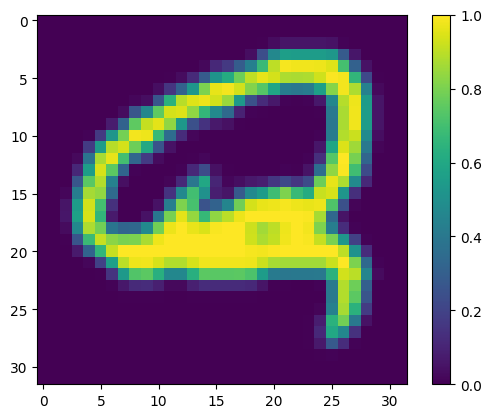





Guessing: 0
Actual: 0


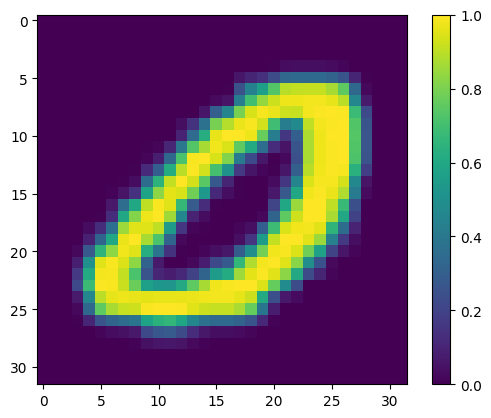





Guessing: 3
Actual: 3


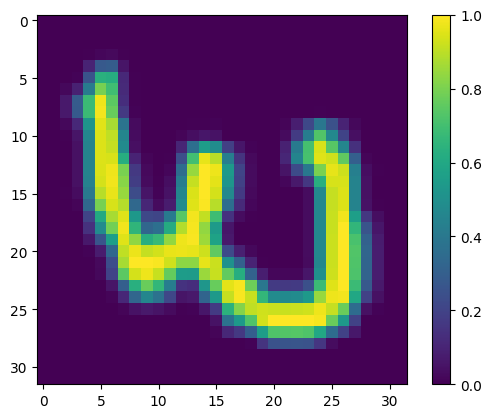





Guessing: X
Actual: X


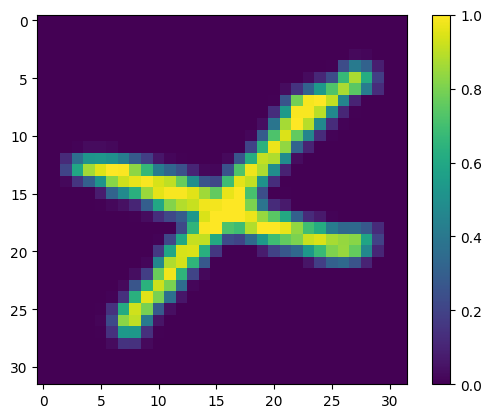





Guessing: U
Actual: U


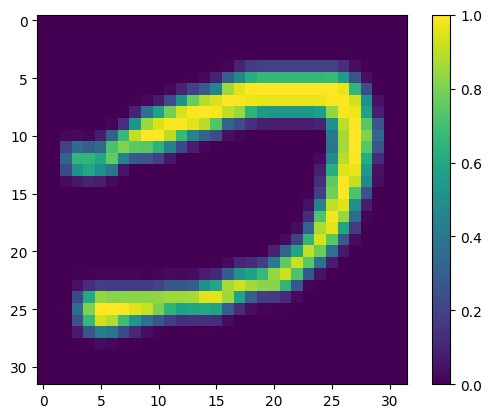

In [48]:
label_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

predictions = model.predict(test_images)

for i in range (0, 5):
    print(f"Guessing: {label_map[np.argmax(predictions[i])]}")
    print(f"Actual: {label_map[np.argmax(test_labels[i])]}")
    draw_number(test_images[i])
    print(f"\n\n\n")
